In [ ]:
#importing necessary modules
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow import keras
from tensorflow.python.framework import ops
from keras.layers import Input,Dense,Activation,Conv2D,Lambda
from keras.models import Model
import cv2,os
from google.colab.patches import cv2_imshow
from google.colab import drive, files

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#defining the Convolutional Module of LLCNN article
def conv_module(x,filter = 64):
  '''Implementation of the convolutional module of LLCNN article.
     Input: The output x of the previous layer
            The number of filters. If not definned then 64 filters are used'''
  #left_part
  x_left = tfl.Conv2D(filters=filter,kernel_size=(3,3),strides=1,padding='same')(x)
  x_left = tfl.ReLU()(x_left)
  x_left = tfl.Conv2D(filters=filter,kernel_size=(3,3),strides=1,padding='same')(x_left)

  #right_part
  x_right = tfl.Conv2D(filters=filter,kernel_size=(1,1),strides=1,padding='same')(x)

  #adding the parts
  x_add = tfl.Add()([x_left,x_right])
  #bottom part
  x_bottom = tfl.ReLU()(x_add)
  x_bottom = tfl.Conv2D(filters=filter,kernel_size=(3,3),strides=1,padding='same')(x_bottom)
  x_bottom = tfl.ReLU()(x_bottom)
  x_bottom = tfl.Conv2D(filters=filter,kernel_size=(3,3),strides=1,padding='same')(x_bottom)

  #adding the x_add and x_bottom
  x_final = tfl.Add()([x_add,x_bottom])

  #final output
  output = tfl.ReLU()(x_final)

  return output

In [ ]:
#defining the LLCNN final model
def LLCNN_model(input_tensor,filters,num_of_modules=5):
  '''Implementing the LLCNN architecture. Inputs are the input tensor
     (the normalized image dataset) and the number of Convolutional modules
     the architecture is going to use. If the number of modules is not definned
     we are using 5 convolutional modules.'''
  #first layer of the architecture
  x = tfl.Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='same')(input_tensor)
  x = tfl.ReLU()(x)

  #series of convolutional modules
  for l in range(num_of_modules):
    x = conv_module(x)

  #three more conv layers
  x = tfl.Conv2D(filters=filters,kernel_size=(1,1),strides=1,padding='same')(x)
  x = tfl.ReLU()(x)
  x = tfl.Conv2D(filters=filters,kernel_size=(1,1),strides=1,padding='same')(x)
  x = tfl.ReLU()(x)
  x = tfl.Conv2D(filters=filters,kernel_size=(1,1),strides=1,padding='same')(x)
  x = tfl.ReLU()(x)
  #output of the model
  outputs = tfl.Conv2D(filters=3,kernel_size=(1,1),strides=1,padding='same')(x)

  return outputs

In [ ]:
#building the model
#input of the model
model_input = Input((625,625,3))
#layers/output of the model
model_output = LLCNN_model(model_input,64,5)
#grouping the layers to form the final model architecture
model = Model(model_input,model_output)

In [ ]:
#defining the loss function of the model
loss = keras.losses.mean_squared_error
#defining the oprimizer of the model
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)

In [ ]:
#compiling the model and printing the summary
model.compile(optimizer=opt,loss=loss,metrics=['mean_squared_error'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 625, 625, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 625, 625, 64  256         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 625, 625, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#mounting the google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#training data
print('Loading the training data...')
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/3.0/Train_LL_3_0.npy'
input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/3.5/Train_LL_3_5.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/4.0/Train_LL_4_0.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/4.5/Train_LL_4_5.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/5.0/Train_LL_5_0.npy'

train_input = np.load(input_path)

#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/3.0/Train_NL_3_0.npy'
output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/3.5/Train_NL_3_5.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/4.0/Train_NL_4_0.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/4.5/Train_NL_4_5.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/training/5.0/Train_NL_5_0.npy'
train_output = np.load(output_path)
print('\nData loaded!')

Loading the training data...

Data loaded!


In [ ]:
#shape of input and output
print('=======================================================================')
print('\t\t\tTRAINING DATA')
print('=======================================================================\n')
print(f'Input shape: {train_input.shape} ')
print(f'Output shape: {train_output.shape}')

print('Reshaping and normalizing the data...')

data = []
for index in range(train_input.shape[0]):
    data.append(train_input[index,0,:,:,:].reshape(train_input.shape[2],train_input.shape[3],train_input.shape[4]))

train_input = np.array(data)
train_input = train_input/255


data = []
for index in range(train_output.shape[0]):
    data.append(train_output[index,0,:,:,:].reshape(train_output.shape[2],train_output.shape[3],train_output.shape[4]))

train_output = np.array(data)
train_output = train_output/255


print(f'Input shape: {train_input.shape} ')
print(f'Output shape: {train_output.shape}')

			TRAINING DATA

Input shape: (722, 1, 625, 625, 3) 
Output shape: (722, 1, 625, 625, 3)
Reshaping and normalizing the data...
Input shape: (722, 625, 625, 3) 
Output shape: (722, 625, 625, 3)


In [ ]:
#real output of the CNN
cnn_output = train_output-train_input
print(cnn_output.shape)

(722, 625, 625, 3)


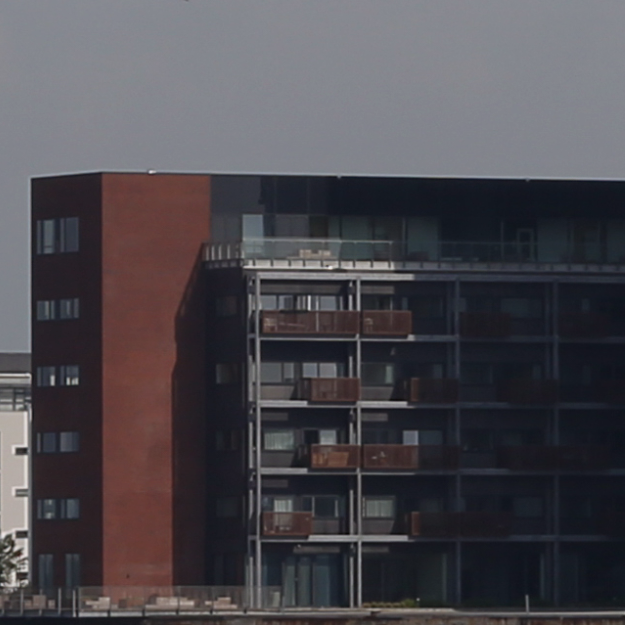

In [ ]:
cv2_imshow(cnn_output[0,:,:,:]*255)

In [ ]:
#validation data
print('Loading the validation data...')
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/3.0/Validation_LL_3_0.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/3.5/Validation_LL_3_5.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/4.0/Validation_LL_4_0.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/4.5/Validation_LL_4_5.npy'
input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/5.0/Validation_LL_5_0.npy'

val_input = np.load(input_path)

#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/3.0/Validation_NL_3_0.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/3.5/Validation_NL_3_5.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/4.0/Validation_NL_4_0.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/4.5/Validation_NL_4_5.npy'
output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/validation/5.0/Validation_NL_5_0.npy'

val_output = np.load(output_path)
print('\nData loaded!')

Loading the validation data...

Data loaded!


In [ ]:
#shape of validation input and output
print('=======================================================================')
print('\t\t\tVALIDATION DATA')
print('=======================================================================\n')
print(f'Input shape: {val_input.shape} ')
print(f'Output shape: {val_output.shape}')

print('Reshaping and normalizing the data...')

data = []
for index in range(val_input.shape[0]):
    data.append(val_input[index,0,:,:,:].reshape(val_input.shape[2],val_input.shape[3],val_input.shape[4]))

val_input = np.array(data)
val_input = val_input/255


data = []
for index in range(val_output.shape[0]):
    data.append(val_output[index,0,:,:,:].reshape(val_output.shape[2],val_output.shape[3],val_output.shape[4]))

val_output = np.array(data)
val_output = val_output/255


print(f'Input shape: {val_input.shape} ')
print(f'Output shape: {val_output.shape}')

del data

			VALIDATION DATA

Input shape: (33, 1, 625, 625, 3) 
Output shape: (33, 1, 625, 625, 3)
Reshaping and normalizing the data...
Input shape: (33, 625, 625, 3) 
Output shape: (33, 625, 625, 3)


In [ ]:
#real validation output
cnn_val = val_output-val_input
print(cnn_val.shape)

(33, 625, 625, 3)


In [ ]:
#training the model
print('Training the model...')
model.fit(train_input, cnn_output, epochs=20, batch_size=5, verbose=1,validation_data=(val_input,cnn_val))
print('\n\nTraining completed!')

Training the model...
Epoch 1/50
109/109 [==============================] - 47s 371ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 2/50
109/109 [==============================] - 39s 359ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 3/50
109/109 [==============================] - 39s 358ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 4/50
109/109 [==============================] - 39s 358ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 5/50
109/109 [==============================] - 39s 358ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 6/50
109/109 [==============================] - 39s 358ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0455 - val_mean_squared_er

# Results on Training Dataset

In [ ]:
#making prediction using the training data
train_dif_pred = model.predict(train_input)

17/17 [==============================] - 16s 877ms/step


In [ ]:
#======================================================
#SAVING THE DIFFERENCES
#======================================================

#===================================
#saving the training prediction difference images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/5 modules'


#saving
for index in range(train_dif_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,train_dif_pred[index,:,:,:]*255)



Saving the result...


In [ ]:
#real predictions on training set
train_pred = train_input + train_dif_pred

In [ ]:
#===================================
#saving the training prediction images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_TrainingSet/5.0/5 modules'


#saving
for index in range(train_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,train_pred[index,:,:,:]*255)

del train_pred,train_dif_pred

Saving the result...


In [ ]:
#doing the same on the validation results
val_dif_pred = model.predict(val_input)

2/2 [==============================] - 1s 812ms/step


In [ ]:
#======================================================
#SAVING THE DIFFERENCES
#======================================================

#===================================
#saving the validation prediction difference images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/5 modules'


#saving
for index in range(val_dif_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,val_dif_pred[index,:,:,:]*255)

Saving the result...


In [ ]:
#real validation results
val_pred = val_input + val_dif_pred

In [ ]:
#======================================================
#SAVING THE DIFFERENCES
#======================================================

#===================================
#saving the validation prediction images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results_ValidationSet/5.0/5 modules'


#saving
for index in range(val_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,val_pred[index,:,:,:]*255)

del val_pred,val_dif_pred

Saving the result...


In [ ]:
#deleting the training data and validation data so we can load the test data
del val_input,val_output,cnn_val
del train_input,train_output,cnn_output

In [ ]:
#test data
print('Loading the test data...')
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/3.0/Test_LL_3_0.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/3.5/Test_LL_3_5.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/4.0/Test_LL_4_0.npy'
#input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/4.5/Test_LL_4_5.npy'
input_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/5.0/Test_LL_5_0.npy'

test_input = np.load(input_path)

#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/3.0/Test_NL_3_0.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/3.5/Test_NL_3_5.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/4.0/Test_NL_4_0.npy'
#output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/4.5/Test_NL_4_5.npy'
output_path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/dataset/test/5.0/Test_NL_5_0.npy'

test_output = np.load(output_path)
print('\nTraining Data Loaded!')

Loading the test data...

Training Data Loaded!


In [ ]:
#shape of test input and output
print('=======================================================================')
print('\t\t\tTEST DATA')
print('=======================================================================\n')
print(f'Input shape: {test_input.shape} ')
print(f'Output shape: {test_output.shape}')

print('Reshaping and normalizing the data...')

data = []
for index in range(test_input.shape[0]):
    data.append(test_input[index,0,:,:,:].reshape(test_input.shape[2],test_input.shape[3],test_input.shape[4]))

test_input = np.array(data)
#normalization
test_input = test_input/255


data = []
for index in range(test_output.shape[0]):
    data.append(test_output[index,0,:,:,:].reshape(test_output.shape[2],test_output.shape[3],test_output.shape[4]))

test_output = np.array(data)
#normalization
test_output = test_output/255


print(f'Input shape: {test_input.shape} ')
print(f'Output shape: {test_output.shape}')

#deleting the temporary list for space economy reasons
del data

			TEST DATA

Input shape: (69, 1, 625, 625, 3) 
Output shape: (69, 1, 625, 625, 3)
Reshaping and normalizing the data...
Input shape: (69, 625, 625, 3) 
Output shape: (69, 625, 625, 3)


In [ ]:
#making prediction with the training set
test_dif_pred = model.predict(test_input)

3/3 [==============================] - 2s 822ms/step


In [ ]:
#======================================================
#SAVING THE DIFFERENCES
#======================================================

#===================================
#saving the test prediction difference images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/DIF_LLCNN+DeepOtsu_Experiment_Results/5.0/5 modules'


#saving
for index in range(test_dif_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,test_dif_pred[index,:,:,:]*255)

Saving the result...


In [ ]:
#real test predictions
test_pred = test_input + test_dif_pred
del test_dif_pred

In [ ]:
#======================================================
#SAVING THE DIFFERENCES
#======================================================

#===================================
#saving the test prediction images
#===================================
print('Saving the result...')
#paths
#===============================================================================
#                         1 convolutional module
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.0/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.5/1 module'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/5.0/1 module'


#===============================================================================
#                         3 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.0/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.5/3 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/5.0/3 modules'


#===============================================================================
#                         5 convolutional modules
#===============================================================================
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/3.5/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.0/5 modules'
#path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/4.5/5 modules'
path = r'/content/drive/MyDrive/DiplomaThesisImageDataset/DataPerLight/LLCNN+DeepOtsu/LLCNN+DeepOtsu_Experiment_Results/5.0/5 modules'


#saving
for index in range(test_pred.shape[0]):
  p = path+'/'+str(index+1)+'.png'
  cv2.imwrite(p,test_pred[index,:,:,:]*255)

Saving the result...
